In [1]:
#####################################################################################################
# This notebook contains example code for reading, visualizing and working with the alignment data. #
# You can reuse the code and expand on it for your own needs.                                       #
#####################################################################################################

#### Log Moves

Here the algorithm makes the trace move a step while the model remains in the current position. So the model does 


In [2]:
#pip install pm4py

In [3]:
#Imports
from mira.prelim.poset import POSet
from mira.nets.firing import NuFiring
from mira.nets.transition import Transition
from mira.nets.marking import NuMarking
from mira.prelim.colors import Color

import numpy as np
import json

import re
import pandas as pd

import os
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2, chi2_contingency

In [4]:
# Helper functions
move_type = lambda name: 'model' if name[0] == '>>' else 'log' if name[1] == '>>' else 'synchronous'
mode = lambda d: {i: v for i, v in enumerate({id for x in d.values() for k in x.keys() for id in k.split(',')} - {'_'})}

In [5]:
# Define the folder containing the JSON files
folder_path = 'C:/Users/20203721/OneDrive - TU Eindhoven/Documents/BEP/data/alignments/bpi_17/individual/'

# Create a list to store all the alignments
alignments = []

# Get the total number of JSON files in the folder
json_files = [filename for filename in os.listdir(folder_path) if filename.endswith('.json')]
total_files = len(json_files)

# Use tqdm to create a single progress bar for the entire loop
with tqdm(total=total_files, desc="Processing JSON files") as pbar:
    for filename in json_files:
        file_path = os.path.join(folder_path, filename)

        # Reading an alignment file
        with open(file_path, 'r') as json_file:
            data = json.load(json_file)
            firings = []
            for e in data['M']:
                transition_name = f'{e[0][0][0]}, {e[0][0][1]}'
                transition_label = f'{e[0][1][0]}, {e[0][1][1]}'
                transition = Transition(transition_name, transition_label, move_type=move_type(e[0][0]))
                firings.append(NuFiring(transition, mode(e[2]), NuMarking(), NuMarking()))

            alignment = POSet(firings, np.matrix(data['r']))
            alignments.append(alignment)

        pbar.update(1)  # Update the progress bar for each processed file

# Now, the 'alignments' list contains all the alignments from the JSON files in the folder

Processing JSON files: 100%|███████████████████████████████████████████████████████████| 26053/26053 [01:23<00:00, 312.80it/s]


In [6]:
# Make lists to store the values
action = []
user = []
case_nr = []
move_type = []

# loop over all alignments and put them in the dataframe
for alignment in alignments:
    sequence = alignment.get_total_order_permutations(1)[0]
    for move in sequence:
        if (f'{move.transition.label.split(", ")[1]}') != "None":
            action.append(f'{move.transition.label.split(", ")[0]}')
            user.append(move.mode[0])
            case_nr.append(move.mode[1])
            move_type.append(move.transition.move_type)

# Initialize dataframe
df = pd.DataFrame({
    'action': action,
    'user': user,
    'case_nr': case_nr,
    'move_type': move_type
})

df

,action,user,case_nr,move_type
0,A Create Application:START,c1000086665,User_11,synchronous
1,A Create Application:COMPLETE,c1000086665,User_11,synchronous
2,W Handle leads withdraw:START,c1000086665,User_1,synchronous
3,W Handle leads withdraw:COMPLETE,c1000086665,User_1,synchronous
4,W Complete application start:START,c1000086665,User_14,synchronous
...,...,...,...,...
606731,W Validate application start:COMPLETE,c999993467,User_116,synchronous
606732,A Pending:START,c999993467,User_30,synchronous
606733,A Pending:COMPLETE,c999993467,User_30,synchronous
606734,W Validate application complete:START,c999993467,User_30,synchronous


In [7]:
#create a mask to identify rows where 'user' and 'case_nr' are swapped
mask = (df['user'].str.startswith('User_') & df['case_nr'].str.startswith('c'))

#swap 'user' and 'case_nr' for the rows identified by the mask
df.loc[mask, ['user', 'case_nr']] = df.loc[mask, ['case_nr', 'user']].values

#rename columns
df.rename(columns={"user": "case_nr", "case_nr": "user"}, inplace=True)

In [8]:
# Filter rows with move_type equal to "log"
log_df = df

# Identify consecutive rows using the default integer index
consecutive_rows = log_df.index.to_series().diff() == 1

# Identify cases where there are at least 2 consecutive actions
cases_with_consecutive_actions = consecutive_rows.groupby(log_df['case_nr']).transform('sum') > 2

# Select rows where there are at least 2 consecutive actions for the same case
result_df = log_df[cases_with_consecutive_actions]

# Display the resulting DataFrame
result_df

,action,case_nr,user,move_type
0,A Create Application:START,c1000086665,User_11,synchronous
1,A Create Application:COMPLETE,c1000086665,User_11,synchronous
2,W Handle leads withdraw:START,c1000086665,User_1,synchronous
3,W Handle leads withdraw:COMPLETE,c1000086665,User_1,synchronous
4,W Complete application start:START,c1000086665,User_14,synchronous
...,...,...,...,...
606731,W Validate application start:COMPLETE,c999993467,User_116,synchronous
606732,A Pending:START,c999993467,User_30,synchronous
606733,A Pending:COMPLETE,c999993467,User_30,synchronous
606734,W Validate application complete:START,c999993467,User_30,synchronous


In [9]:
# Check if all cases have more than 2 observations
# When this is true, the outut of this is the length of the series printed below.
result_df['case_nr'].nunique()

26113

In [10]:
at_least_2 = result_df.groupby('case_nr').size() > 2
print(at_least_2[at_least_2])

case_nr
User_1        True
User_10       True
User_100      True
User_101      True
User_11       True
              ... 
c99940018     True
c999464866    True
c999487618    True
c999544538    True
c999993467    True
Length: 26113, dtype: bool


In [11]:
# Get next log move using shift
result_df['next_event'] = result_df.groupby('case_nr')['action'].shift(-2)
result_df['next_event_type'] = result_df.groupby('case_nr')['move_type'].shift(-2)

result_df

C:\Users\20203721\AppData\Local\Temp\ipykernel_3984\734093137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['next_event'] = result_df.groupby('case_nr')['action'].shift(-2)
C:\Users\20203721\AppData\Local\Temp\ipykernel_3984\734093137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['next_event_type'] = result_df.groupby('case_nr')['move_type'].shift(-2)


,action,case_nr,user,move_type,next_event,next_event_type
0,A Create Application:START,c1000086665,User_11,synchronous,W Handle leads withdraw:START,synchronous
1,A Create Application:COMPLETE,c1000086665,User_11,synchronous,W Handle leads withdraw:COMPLETE,synchronous
2,W Handle leads withdraw:START,c1000086665,User_1,synchronous,W Complete application start:START,synchronous
3,W Handle leads withdraw:COMPLETE,c1000086665,User_1,synchronous,W Complete application start:COMPLETE,synchronous
4,W Complete application start:START,c1000086665,User_14,synchronous,A Accepted:START,synchronous
...,...,...,...,...,...,...
606731,W Validate application start:COMPLETE,c999993467,User_116,synchronous,A Pending:COMPLETE,synchronous
606732,A Pending:START,c999993467,User_30,synchronous,W Validate application complete:START,synchronous
606733,A Pending:COMPLETE,c999993467,User_30,synchronous,W Validate application complete:COMPLETE,synchronous
606734,W Validate application complete:START,c999993467,User_30,synchronous,NaN,NaN


In [12]:
# Drop :COMPLETE observations, thereby halving the dataset. Possible because it's not needed for this research
result_df = result_df[~result_df['action'].str.endswith(':COMPLETE')]
result_df['action'] = result_df['action'].str.replace(':START', '')
result_df['next_event'] = result_df['next_event'].str.replace(':START', '')

result_df

C:\Users\20203721\AppData\Local\Temp\ipykernel_3984\3531211597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['action'] = result_df['action'].str.replace(':START', '')
C:\Users\20203721\AppData\Local\Temp\ipykernel_3984\3531211597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['next_event'] = result_df['next_event'].str.replace(':START', '')


,action,case_nr,user,move_type,next_event,next_event_type
0,A Create Application,c1000086665,User_11,synchronous,W Handle leads withdraw,synchronous
2,W Handle leads withdraw,c1000086665,User_1,synchronous,W Complete application start,synchronous
4,W Complete application start,c1000086665,User_14,synchronous,A Accepted,synchronous
6,A Accepted,c1000086665,User_5,synchronous,W Complete application ate abort,synchronous
8,W Complete application ate abort,c1000086665,User_5,synchronous,W Call after offers start,synchronous
...,...,...,...,...,...,...
606726,W Call after offers start,c999993467,User_49,synchronous,W Call after offers ate abort,synchronous
606728,W Call after offers ate abort,c999993467,User_116,synchronous,W Validate application start,synchronous
606730,W Validate application start,c999993467,User_116,synchronous,A Pending,synchronous
606732,A Pending,c999993467,User_30,synchronous,W Validate application complete,synchronous


### Make a matrix of how many times two log moves come in pairs <br>
Y-axis: current event<br>
X-axis: next event<br>

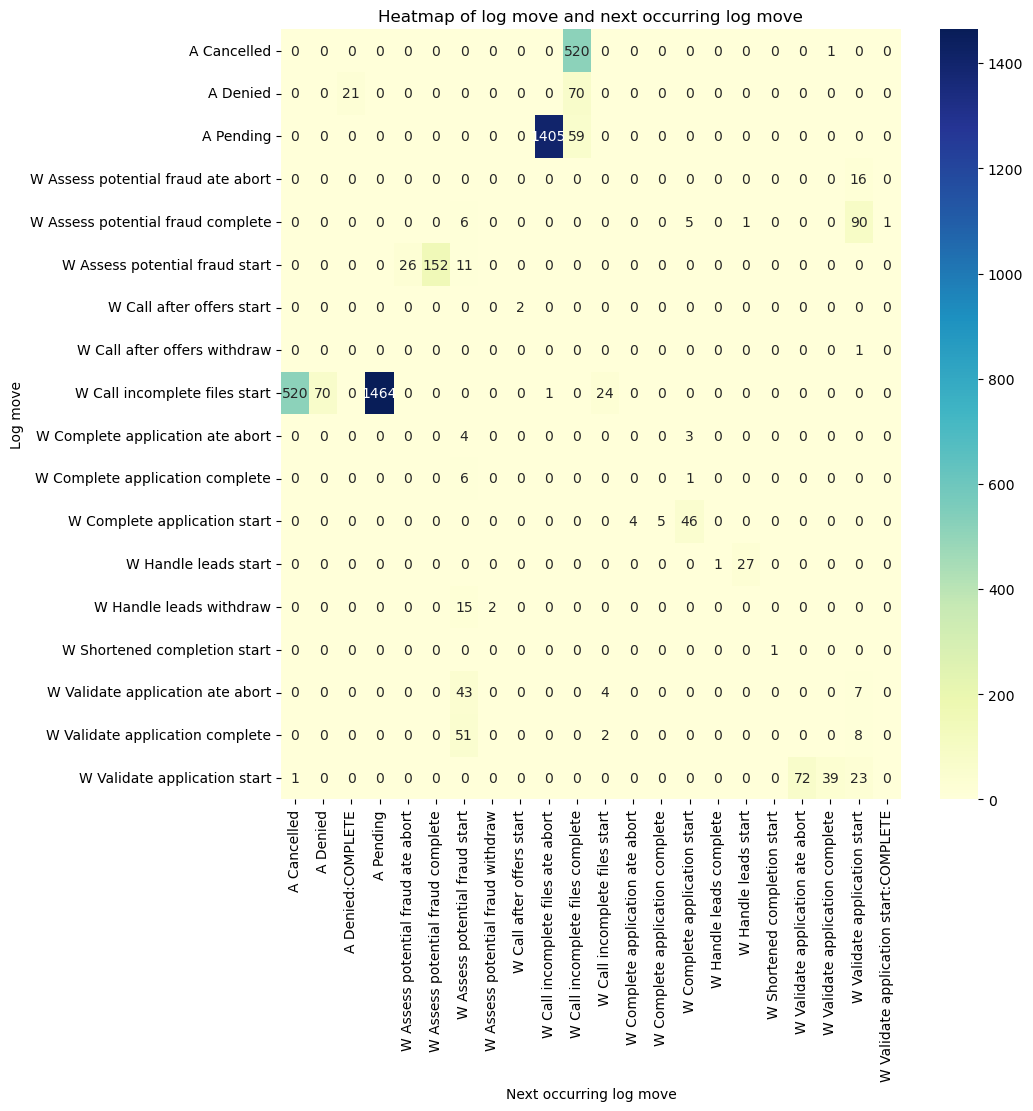

In [13]:
# Create a heatmap
heatmap_data = result_df[(result_df['move_type'] == 'log') & (result_df['next_event_type'] == 'log')].pivot_table(index='action', columns='next_event', aggfunc='size', fill_value=0)

plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Heatmap of log move and next occurring log move')
plt.xlabel('Next occurring log move')
plt.ylabel('Log move')
plt.show()

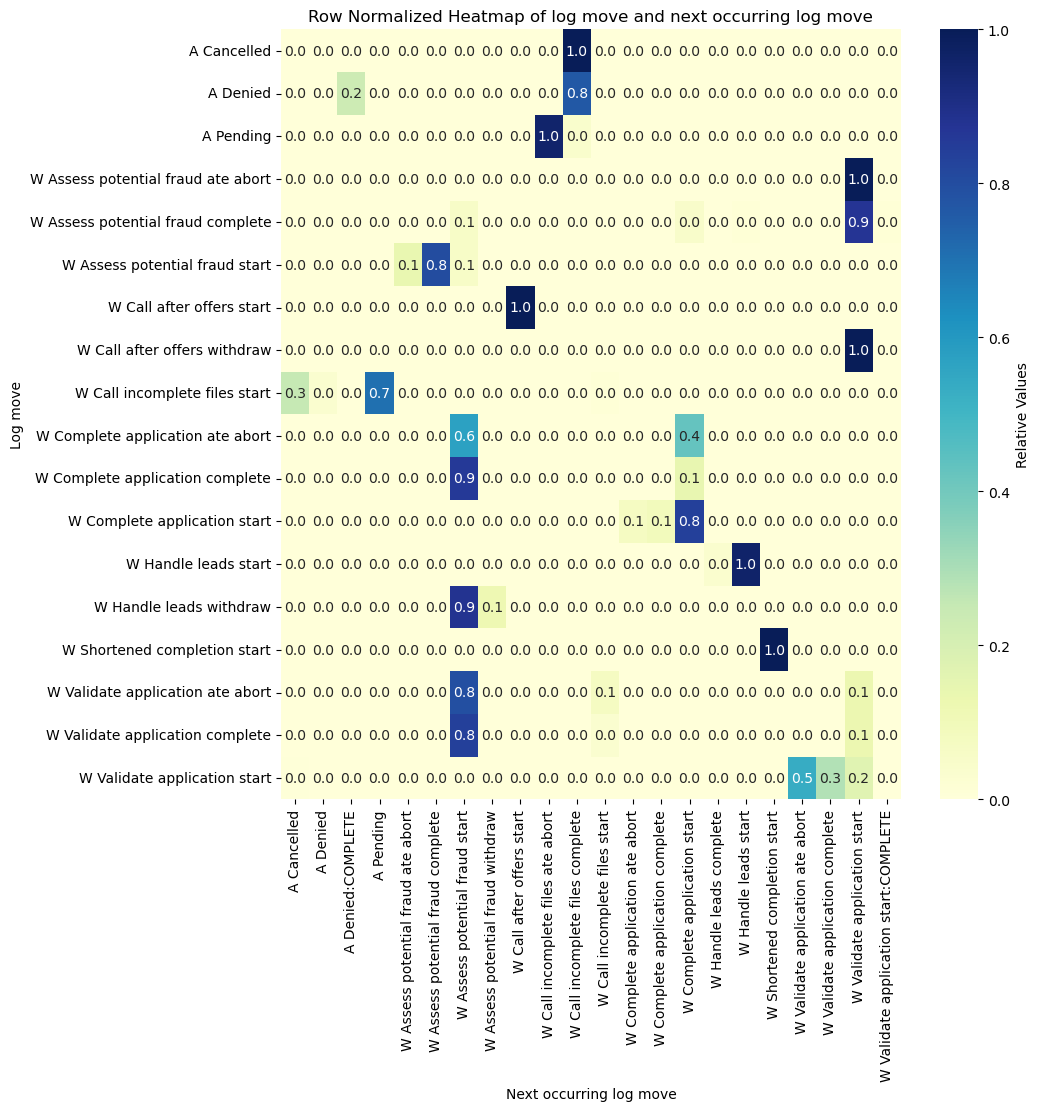

In [14]:
normalized_df = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

plt.figure(figsize=(10, 10))

# Create the heatmap
sns.heatmap(normalized_df, cmap='YlGnBu', annot=True, fmt=".1f", cbar_kws={'label': 'Relative Values'})
plt.title('Row Normalized Heatmap of log move and next occurring log move')
plt.xlabel('Next occurring log move')
plt.ylabel('Log move')
# Show the plot
plt.show()

In [15]:
heatmap_data

next_event,A Cancelled,A Denied,A Denied:COMPLETE,A Pending,W Assess potential fraud ate abort,W Assess potential fraud complete,W Assess potential fraud start,W Assess potential fraud withdraw,W Call after offers start,W Call incomplete files ate abort,...,W Complete application ate abort,W Complete application complete,W Complete application start,W Handle leads complete,W Handle leads start,W Shortened completion start,W Validate application ate abort,W Validate application complete,W Validate application start,W Validate application start:COMPLETE
action,,,,,,,,,,,,,,,,,,,,,
A Cancelled,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
A Denied,0,0,21,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A Pending,0,0,0,0,0,0,0,0,0,1405,...,0,0,0,0,0,0,0,0,0,0
W Assess potential fraud ate abort,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,16,0
W Assess potential fraud complete,0,0,0,0,0,0,6,0,0,0,...,0,0,5,0,1,0,0,0,90,1
W Assess potential fraud start,0,0,0,0,26,152,11,0,0,0,...,0,0,0,0,0,0,0,0,0,0
W Call after offers start,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
W Call after offers withdraw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
W Call incomplete files start,520,70,0,1464,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [16]:
row_results = pd.DataFrame(columns=['Action', 'Max', 'Next Event', 'Sum of row'])

# Loop over each row and find the maximum number and its label
for index, row in heatmap_data.iterrows():
    action = index
    max_row_value = row.max()
    next_event = row.idxmax()
    sum_row = row.sum()
 
    new_row = pd.DataFrame({'Action': [action], 'Max': [max_row_value], 'Next Event': [next_event], 'Sum of row': [sum_row]})
    row_results = pd.concat([row_results, new_row], ignore_index=True)
    
row_results

,Action,Max,Next Event,Sum of row
0,A Cancelled,520,W Call incomplete files complete,521
1,A Denied,70,W Call incomplete files complete,91
2,A Pending,1405,W Call incomplete files ate abort,1464
3,W Assess potential fraud ate abort,16,W Validate application start,16
4,W Assess potential fraud complete,90,W Validate application start,103
5,W Assess potential fraud start,152,W Assess potential fraud complete,189
6,W Call after offers start,2,W Call after offers start,2
7,W Call after offers withdraw,1,W Validate application start,1
8,W Call incomplete files start,1464,A Pending,2079
9,W Complete application ate abort,4,W Assess potential fraud start,7


In [17]:
column_results = pd.DataFrame(columns=['Next Event', 'Sum of column'])

# Loop over each row and find the maximum number and its label
for index, column in heatmap_data.items():
    sum_col = column.values.sum()
 
    new_row = pd.DataFrame({'Next Event': [index], 'Sum of column': [sum_col]})
    column_results = pd.concat([column_results, new_row], ignore_index=True)
    
column_results

,Next Event,Sum of column
0,A Cancelled,521
1,A Denied,70
2,A Denied:COMPLETE,21
3,A Pending,1464
4,W Assess potential fraud ate abort,26
5,W Assess potential fraud complete,152
6,W Assess potential fraud start,136
7,W Assess potential fraud withdraw,2
8,W Call after offers start,2
9,W Call incomplete files ate abort,1406


In [18]:
indep_outcomes = pd.DataFrame(columns=['Event', 'Next Event', 'Yes/Yes', 'Yes/No', 'No/Yes', 'No/No'])

column_result_dict = column_results.set_index('Next Event')['Sum of column'].to_dict()

total = row_results['Sum of row'].sum()

for index, row in row_results.iterrows():
    yes_yes = row['Max']
    yes_no = row['Sum of row'] - row['Max']
    no_yes = (column_result_dict.get(row['Next Event'], 0)) - row['Max']
    #no_no = total - column_result_dict.get(row['Next Event'], 0)
    no_no = total - yes_yes - yes_no - no_yes
    
    new_row = pd.DataFrame({'Event': row['Action'], 'Next Event': row['Next Event'], 'Yes/Yes': yes_yes,
                            'Yes/No': yes_no , 'No/Yes': no_yes, 'No/No': no_no}, index=[0])
    indep_outcomes = pd.concat([indep_outcomes, new_row], ignore_index=True)
    
indep_outcomes

,Event,Next Event,Yes/Yes,Yes/No,No/Yes,No/No
0,A Cancelled,W Call incomplete files complete,520,1,129,4181
1,A Denied,W Call incomplete files complete,70,21,579,4161
2,A Pending,W Call incomplete files ate abort,1405,59,1,3366
3,W Assess potential fraud ate abort,W Validate application start,16,0,129,4686
4,W Assess potential fraud complete,W Validate application start,90,13,55,4673
5,W Assess potential fraud start,W Assess potential fraud complete,152,37,0,4642
6,W Call after offers start,W Call after offers start,2,0,0,4829
7,W Call after offers withdraw,W Validate application start,1,0,144,4686
8,W Call incomplete files start,A Pending,1464,615,0,2752
9,W Complete application ate abort,W Assess potential fraud start,4,3,132,4692


# Chi-square test by hand

Steps: <br>
    1. Have contingency table<br>
    2. Calculate the chi-squared statistic<br>
          Chi-square = $Σ [(Oij - Eij)² / Eij]$<br>
          $Oij$: Observed count in cell (i, j)<br>
          $Eij$: Expected count in cell (i, j)<br>
          The expected count $Eij$ is calculated based on the assumption of independence, which is given by:<br>
            $Eij$ = (Row i's total count * Column j's total count) / Grand Total <br>
    3. Determine degrees of freedom (df)<br>
        The degrees of freedom for a chi-squared test for independence can be calculated as df = (R - 1) * (C - 1), where R is the number of rows and C is the number of columns in the contingency table <br>
    4. Find the critical value using the Chi-square distribution table <br>
    5. Calculate the Chi-square value
    6. Reject Null-hypothesis when Chi_square $\ge$ critical value
          

In [19]:
# Sum of Yes/Yes, Yes/No and No/Yes must be above the defined threshold

threshold = 50
indep_outcomes = indep_outcomes[indep_outcomes.iloc[:, -4:-2].sum(axis=1) > threshold]

indep_outcomes = indep_outcomes.reset_index(drop=True)
indep_outcomes

,Event,Next Event,Yes/Yes,Yes/No,No/Yes,No/No
0,A Cancelled,W Call incomplete files complete,520,1,129,4181
1,A Denied,W Call incomplete files complete,70,21,579,4161
2,A Pending,W Call incomplete files ate abort,1405,59,1,3366
3,W Assess potential fraud complete,W Validate application start,90,13,55,4673
4,W Assess potential fraud start,W Assess potential fraud complete,152,37,0,4642
5,W Call incomplete files start,A Pending,1464,615,0,2752
6,W Complete application start,W Complete application start,46,9,9,4767
7,W Validate application ate abort,W Assess potential fraud start,43,11,93,4684
8,W Validate application complete,W Assess potential fraud start,51,10,85,4685
9,W Validate application start,W Validate application ate abort,72,63,0,4696


In [20]:
# For each pair, calculate all expected outcomes

indep_outcomes['exp_yes/yes'] = ((indep_outcomes['Yes/Yes'] + indep_outcomes['No/Yes']) * (indep_outcomes['Yes/Yes'] + indep_outcomes['Yes/No']))/ (indep_outcomes['Yes/Yes'] + indep_outcomes['Yes/No'] + indep_outcomes['No/Yes'] + indep_outcomes['No/No'])
indep_outcomes['exp_yes/no'] = ((indep_outcomes['Yes/No'] + indep_outcomes['No/No']) * (indep_outcomes['Yes/Yes'] + indep_outcomes['Yes/No']))/ (indep_outcomes['Yes/Yes'] + indep_outcomes['Yes/No'] + indep_outcomes['No/Yes'] + indep_outcomes['No/No'])
indep_outcomes['exp_no/yes'] = ((indep_outcomes['Yes/Yes'] + indep_outcomes['No/Yes']) * (indep_outcomes['No/Yes'] + indep_outcomes['No/No']))/ (indep_outcomes['Yes/Yes'] + indep_outcomes['Yes/No'] + indep_outcomes['No/Yes'] + indep_outcomes['No/No'])
indep_outcomes['exp_no/no'] = ((indep_outcomes['Yes/No'] + indep_outcomes['No/No']) * (indep_outcomes['No/Yes'] + indep_outcomes['No/No']))/ (indep_outcomes['Yes/Yes'] + indep_outcomes['Yes/No'] + indep_outcomes['No/Yes'] + indep_outcomes['No/No'])

# Calculate Chi-square value
indep_outcomes['Chi_sqrt'] = ((((indep_outcomes['Yes/Yes']-indep_outcomes['exp_yes/yes'])**2)/indep_outcomes['exp_yes/yes']) +
                              (((indep_outcomes['Yes/No']-indep_outcomes['exp_yes/no'])**2)/indep_outcomes['exp_yes/no']) +
                              (((indep_outcomes['No/Yes']-indep_outcomes['exp_no/yes'])**2)/indep_outcomes['exp_no/yes']) +
                              (((indep_outcomes['No/No']-indep_outcomes['exp_no/no'])**2)/indep_outcomes['exp_no/no']))

In [21]:
indep_outcomes

,Event,Next Event,Yes/Yes,Yes/No,No/Yes,No/No,exp_yes/yes,exp_yes/no,exp_no/yes,exp_no/no,Chi_sqrt
0,A Cancelled,W Call incomplete files complete,520,1,129,4181,69.991513,451.008487,579.008487,3730.991513,3746.353915
1,A Denied,W Call incomplete files complete,70,21,579,4161,12.225005,78.774995,636.774995,4103.225005,321.471505
2,A Pending,W Call incomplete files ate abort,1405,59,1,3366,426.078245,1037.921755,979.921755,2387.078245,4551.735144
3,W Assess potential fraud complete,W Validate application start,90,13,55,4673,3.091492,99.908508,141.908508,4586.091492,2573.657302
4,W Assess potential fraud start,W Assess potential fraud complete,152,37,0,4642,5.946595,183.053405,146.053405,4495.946595,3854.525403
5,W Call incomplete files start,A Pending,1464,615,0,2752,630.026082,1448.973918,833.973918,1918.026082,2780.538662
6,W Complete application start,W Complete application start,46,9,9,4767,0.626164,54.373836,54.373836,4721.626164,3364.093706
7,W Validate application ate abort,W Assess potential fraud start,43,11,93,4684,1.520182,52.479818,134.479818,4642.520182,1177.772168
8,W Validate application complete,W Assess potential fraud start,51,10,85,4685,1.717243,59.282757,134.282757,4635.717243,1473.935189
9,W Validate application start,W Validate application ate abort,72,63,0,4696,2.012006,132.987994,69.987994,4626.012006,2542.424991


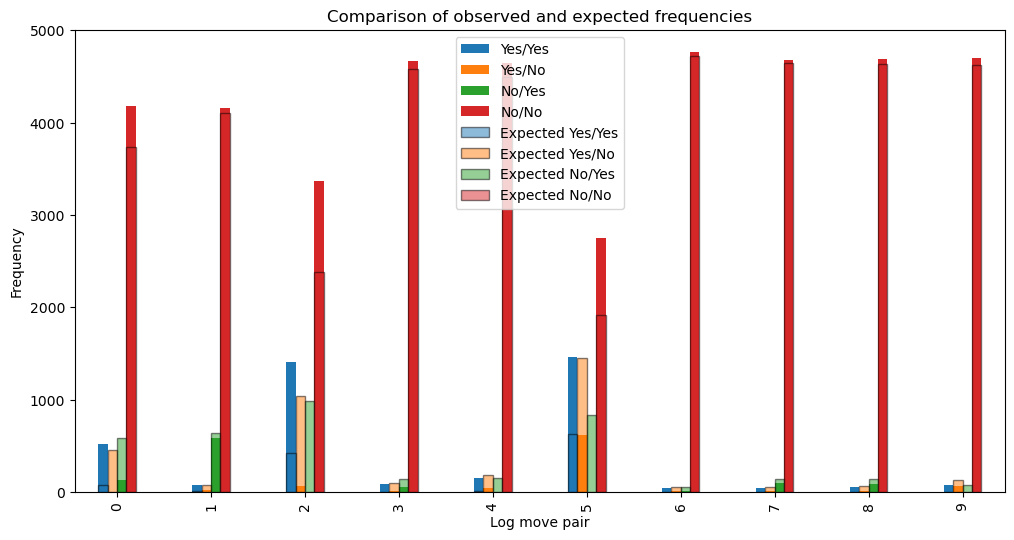

In [22]:
# Comparing the observed and expected freqencies
observed_cols = ['Yes/Yes', 'Yes/No', 'No/Yes', 'No/No']
expected_cols = ['exp_yes/yes', 'exp_yes/no', 'exp_no/yes', 'exp_no/no']

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
indep_outcomes[observed_cols].plot(kind='bar',  ax=ax, width=0.4)
indep_outcomes[expected_cols].plot(kind='bar',  ax=ax, width=0.4, alpha=0.5, edgecolor='black')

plt.title('Comparison of observed and expected frequencies')
plt.xlabel('Log move pair')
plt.ylabel('Frequency')
plt.legend(['Yes/Yes', 'Yes/No', 'No/Yes', 'No/No', 'Expected Yes/Yes', 'Expected Yes/No', 'Expected No/Yes', 'Expected No/No'])
plt.show()

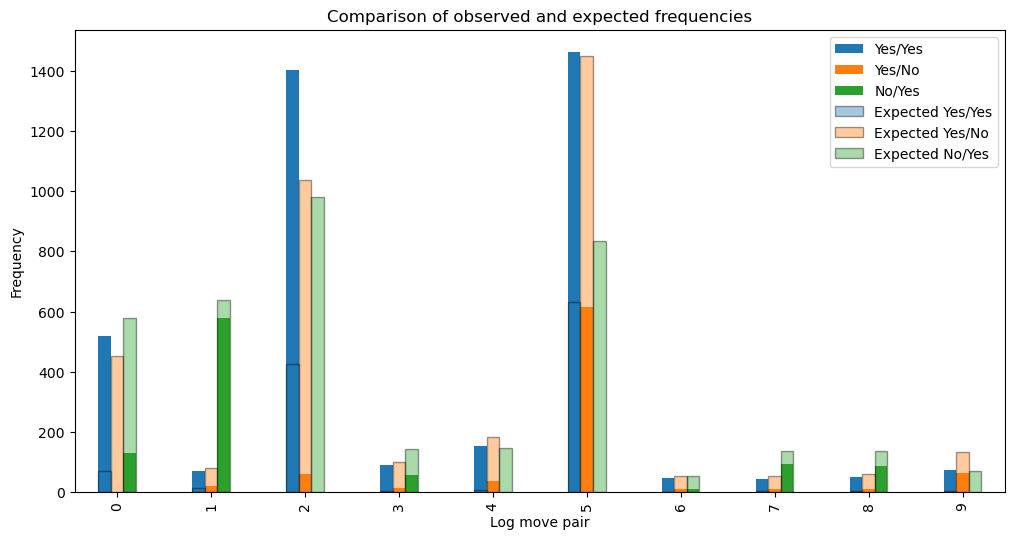

In [23]:
# Comparing the observed and expected freqencies leaving out the No/No pairs
observed_cols = ['Yes/Yes', 'Yes/No', 'No/Yes']
expected_cols = ['exp_yes/yes', 'exp_yes/no', 'exp_no/yes']

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
indep_outcomes[observed_cols].plot(kind='bar', ax=ax, width=0.4)
indep_outcomes[expected_cols].plot(kind='bar', ax=ax, width=0.4, alpha=0.4, edgecolor='black')

plt.title('Comparison of observed and expected frequencies')
plt.xlabel('Log move pair')
plt.ylabel('Frequency')
plt.legend(['Yes/Yes', 'Yes/No', 'No/Yes', 'Expected Yes/Yes', 'Expected Yes/No', 'Expected No/Yes'])
plt.show()

In [24]:
# Critical value from the chi-square distribution table
critical_value = 3.841

reject_pairs = []
accept_pairs = []

# Check if the Chi-square values are larger than the critical value,
# if so, append to the rejected pairs list, otherwise append to the accepted pairs list.
for index, row in indep_outcomes.iterrows():
    if row['Chi_sqrt'] > critical_value:
        reject_pairs.append((row['Event'], row['Next Event'], "Chi-square value: " + str(round(row['Chi_sqrt'], 2))))
    else:
        accept_pairs.append((row['Event'], row['Next Event'], "Chi-square value: " + str(round(row['Chi_sqrt'], 2))))

print("Reject the null hypothesis for the following pairs of events:")
for pair in reject_pairs:
    print(pair)

print("\nAccept the null hypothesis for the following pairs of events:")
for pair in accept_pairs:
    print(pair)


Reject the null hypothesis for the following pairs of events:
('A Cancelled', 'W Call incomplete files complete', 'Chi-square value: 3746.35')
('A Denied', 'W Call incomplete files complete', 'Chi-square value: 321.47')
('A Pending', 'W Call incomplete files ate abort', 'Chi-square value: 4551.74')
('W Assess potential fraud complete', 'W Validate application start', 'Chi-square value: 2573.66')
('W Assess potential fraud start', 'W Assess potential fraud complete', 'Chi-square value: 3854.53')
('W Call incomplete files start', 'A Pending', 'Chi-square value: 2780.54')
('W Complete application start', 'W Complete application start', 'Chi-square value: 3364.09')
('W Validate application ate abort', 'W Assess potential fraud start', 'Chi-square value: 1177.77')
('W Validate application complete', 'W Assess potential fraud start', 'Chi-square value: 1473.94')
('W Validate application start', 'W Validate application ate abort', 'Chi-square value: 2542.42')

Accept the null hypothesis for t

# Chi-square test for independence using scipy.stats

Null Hypothesis: There is no relation between log move A and log move B.<br>
Alternative Hypothesis: There is a relation between log move A and log move B.

In [25]:
# Critical value from the chi-square distribution table
critical_value = 3.841

reject_pairs = []
accept_pairs = []

# Check if the Chi-square values are larger than the critical value,
# if so, append to the rejected pairs list, otherwise append to the accepted pairs list.
for index, row in indep_outcomes.iterrows():
    if row['Chi_sqrt'] > critical_value:
        reject_pairs.append((row['Event'], row['Next Event'], "Chi-square value: " + str(round(row['Chi_sqrt'], 2))))
    else:
        accept_pairs.append((row['Event'], row['Next Event'], "Chi-square value: " + str(round(row['Chi_sqrt'], 2))))

        
print("Accept the null hypothesis for the following pairs of events:")
for pair in accept_pairs:
    print(pair)  
        
print("\nReject the null hypothesis for the following pairs of events:")
for pair in reject_pairs:
    print(pair)

Accept the null hypothesis for the following pairs of events:

Reject the null hypothesis for the following pairs of events:
('A Cancelled', 'W Call incomplete files complete', 'Chi-square value: 3746.35')
('A Denied', 'W Call incomplete files complete', 'Chi-square value: 321.47')
('A Pending', 'W Call incomplete files ate abort', 'Chi-square value: 4551.74')
('W Assess potential fraud complete', 'W Validate application start', 'Chi-square value: 2573.66')
('W Assess potential fraud start', 'W Assess potential fraud complete', 'Chi-square value: 3854.53')
('W Call incomplete files start', 'A Pending', 'Chi-square value: 2780.54')
('W Complete application start', 'W Complete application start', 'Chi-square value: 3364.09')
('W Validate application ate abort', 'W Assess potential fraud start', 'Chi-square value: 1177.77')
('W Validate application complete', 'W Assess potential fraud start', 'Chi-square value: 1473.94')
('W Validate application start', 'W Validate application ate abort',

In [26]:
# all p values are below 0.05 reject null hypothesis. So, there is a relation between Event A and event B